In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output


In [104]:
# Any results you write to the current directory are saved as output
print(check_output(["ls", "../content"]).decode("utf8"))

sample_data
sample_submission.csv
test.csv
train.csv



## **Load Train and Test Data**

In [105]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
test= pd.read_csv("test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
type(train)

pandas.core.frame.DataFrame

In [107]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [108]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [109]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

The output variable is an integer from 0 to 9. This is a **multiclass** classification problem.

# Data Visualization

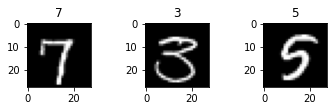

In [110]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [111]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train.shape

(42000, 28, 28, 1)

In [112]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

# Preprocessing the Digit Images

## Feature Standardization
It is important preprocessing step. It is used to centre the data around zero mean and unit variance.

In [113]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x):
  return (x - mean_px)/std_px

## One Hot Encoding of Labels
A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension.

For example, 3 would be [0,0,0,1,0,0,0,0,0,0].

In [114]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

Lets plot the 10th label

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


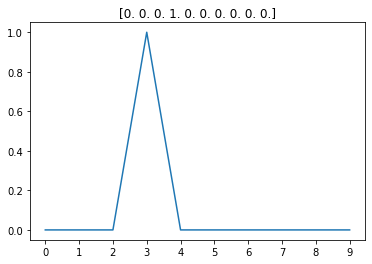

In [115]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

# Designing Neural Network Architecture

In [116]:
seed = 43
np.random.seed(seed)

### Linear Model

In [117]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

Lets create a simple model from Keras Sequential layer.

Lambda layer performs simple arithmetic operations like sum, average, exponentiation etc.

In 1st layer of the model we have to define input dimensions of our data in (rows, columns, colour channel) format. (In theano colour channel comes first)

Flatten will transform input into 1D array.
Dense is fully connected layer that means all neurons in previous layers will be connected to all neurons in fully connected layer. In the last layer we have to specify output dimensions/classes of the model. Here it's 10, since we have to output 10 different digit labels.

In [118]:
model = Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


### Compile Network
Before making network ready for training we have to make sure to add below things:

A loss function: to measure how good the network is

An optimizer: to update network as it sees more data and reduce loss value

Metrics: to monitor performance of network

In [119]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss = 'categorical_crossentropy',
 metrics = ['accuracy'])

In [120]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

### Cross-Validation

In [136]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.10,
                                                  random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [146]:
steps_per_epoch = len(X_train) // 64
validation_steps = len(X_val) // 64

In [147]:
steps_per_epoch

478

In [148]:
history=model.fit(x=batches, steps_per_epoch=steps_per_epoch,
                            epochs=3, validation_data=val_batches,
                            validation_steps=validation_steps)

Epoch 1/3
478/478 [==============================] - 1s 3ms/step - loss: 0.2505 - accuracy: 0.9328 - val_loss: 0.2561 - val_accuracy: 0.9307
Epoch 2/3
478/478 [==============================] - 1s 3ms/step - loss: 0.2492 - accuracy: 0.9343 - val_loss: 0.2584 - val_accuracy: 0.9263
Epoch 3/3
478/478 [==============================] - 1s 3ms/step - loss: 0.2472 - accuracy: 0.9338 - val_loss: 0.2520 - val_accuracy: 0.9287


In [149]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

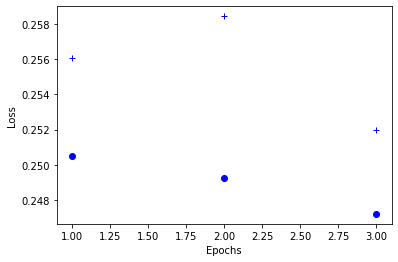

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

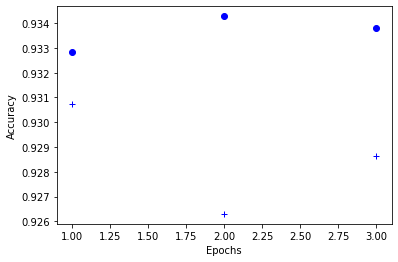

In [152]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

## Fully Connected Model
Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Adding another Dense Layer to model.

In [153]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [154]:
fc = get_fc_model()
fc.optimizer.lr=0.01

In [160]:
steps_per_epoch = len(X_train)//64

In [162]:
steps_per_epoch

478

In [161]:
history=fc.fit(x=batches, steps_per_epoch=steps_per_epoch,
               epochs=1, 
               validation_data=val_batches,
               validation_steps=validation_steps)

478/478 [==============================] - 3s 7ms/step - loss: 0.1774 - accuracy: 0.9537 - val_loss: 0.2788 - val_accuracy: 0.9496


# Convolutional Neural Network
CNNs are extremely efficient for images.

In [163]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [164]:
model= get_cnn_model()
model.optimizer.lr=0.01

In [166]:
history=model.fit(x=batches, steps_per_epoch=steps_per_epoch,
                  epochs=1, validation_data=val_batches,
                  validation_steps=validation_steps)

478/478 [==============================] - 71s 149ms/step - loss: 0.1745 - accuracy: 0.9469 - val_loss: 0.1038 - val_accuracy: 0.9688


## Data Augmentation
It is tehnique of showing slighly different or new images to neural network to avoid overfitting. And to achieve better generalization. In case you have very small dataset, you can use different kinds of data augmentation techniques to increase your data size. Neural networks perform better if you provide them more data.

Different data aumentation techniques are as follows:

Cropping
Rotating
Scaling
Translating
Flipping
Adding Gaussian noise to input images etc.

In [168]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08,
                        shear_range=0.3, height_shift_range=0.08,
                        zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [170]:
model.optimizer.lr=0.001
history=model.fit(x=batches, steps_per_epoch=steps_per_epoch,
                  epochs=1, validation_data=val_batches,
                  validation_steps=validation_steps)

478/478 [==============================] - 79s 165ms/step - loss: 0.1662 - accuracy: 0.9497 - val_loss: 0.1363 - val_accuracy: 0.9546


# Adding Batch Normalization
BN helps to fine tune hyperparameters more better and train really deep neural networks.

In [171]:
from keras.layers.normalization import BatchNormalization

def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [174]:
steps_per_epoch = len(X_train)//64
steps_per_epoch

478

In [175]:
model= get_bn_model()
model.optimizer.lr=0.01
history=model.fit(x=batches, steps_per_epoch=steps_per_epoch,
                  epochs=1, validation_data=val_batches,
                  validation_steps=validation_steps)

478/478 [==============================] - 105s 218ms/step - loss: 0.4837 - accuracy: 0.8812 - val_loss: 0.1388 - val_accuracy: 0.9661


# Submitting Predictions to Kaggle.
Make sure you use full train dataset here to train model and predict on test set.

In [176]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit(x=batches,
                  steps_per_epoch=steps_per_epoch,
                  epochs=3)

Epoch 1/3
478/478 [==============================] - 94s 197ms/step - loss: 0.0621 - accuracy: 0.9824
Epoch 2/3
478/478 [==============================] - 95s 199ms/step - loss: 0.0422 - accuracy: 0.9867
Epoch 3/3
478/478 [==============================] - 97s 204ms/step - loss: 0.0373 - accuracy: 0.9886
